In [10]:
# todo: work on imports
import sys
sys.path.append("../")
from mir.common import parser, Repertoire, SegmentLibrary
from mir.distances import ClonotypeAligner, AlignGermline
from mir.comparative import DenseMatch

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time
import umap as um

Load prototypes

In [2]:
lib = SegmentLibrary.load_default()
db = Repertoire(parser.parse_olga('assets/olga_humanTRB.txt', lib=lib, n=1000))
print(db)

Repertoire of 1000 clonotypes and 1000 cells:
Clonotype 0 CASSWGKGRGLRTDTQYF TGCGCCAGCAGCTGGGGAAAGGGGAGGGGCCTCCGCACAGATACGCAGTATTTT
Clonotype 1 CASSIIVRGIQNTEAFF TGTGCCAGTAGTATTATCGTCAGGGGGATTCAGAACACTGAAGCTTTCTTT
Clonotype 2 CASSLAWGPRNQPQHF TGTGCCAGCAGTTTAGCTTGGGGACCCCGCAATCAGCCCCAGCATTTT
Clonotype 3 CASSLARGAYEQYF TGCGCCAGCAGCTTGGCTCGGGGGGCCTACGAGCAGTACTTC
Clonotype 4 CASSQAVLYEKLFF TGCGCCAGCAGCCAGGCGGTACTTTATGAAAAACTGTTTTTT
...


Load VDJdb excl. 10X

In [3]:
tenxref = "https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#"
data = parser.parse_vdjdb_slim('assets/vdjdb.slim.txt', lib=lib, gene='TRB', species='HomoSapiens', 
                               warn=False, 
                               filter=lambda x: x[x['reference.id'] != tenxref])
data = [x for x in data if len(x.cdr3aa) in range(7, 23)]
#data = data[0:1000]
print(data[0:10])
len(data)

[Clonotype 7 CASSAFPCREGRNNEQFF, Clonotype 13 CASSHGVGQGPYEQYF, Clonotype 14 CASSLTTESGEQYF, Clonotype 26 CASSLGTLEETQYF, Clonotype 34 CASIPEGGRETQYF, Clonotype 43 CASSLDSLNTIYF, Clonotype 44 CASSQDTASSYEQYF, Clonotype 48 CASSLSYRGNSPLHF, Clonotype 58 CSADGLPISSYNEQFF, Clonotype 59 CASTRADTGELFF]


23714

Initialize aligners

In [4]:
valign = AlignGermline.from_seqs(lib.get_seqaas(gene='TRB', stype='V'))
jalign = AlignGermline.from_seqs(lib.get_seqaas(gene='TRB', stype='J'))
aligner = ClonotypeAligner(v_aligner=valign, j_aligner=jalign)
matcher = DenseMatch(db, aligner)

Test class methods

In [5]:
''.join(str(x) for x in matcher.match_single(data[0]))
[m.__dict__() for m in matcher.match_single(data[0])]
[m.__dict__() for m in matcher.match(data[0:1])]
matcher.match_to_df(data[0:10])

,id,0_v_score,0_j_score,0_cdr3_score,1_v_score,1_j_score,1_cdr3_score,2_v_score,2_j_score,2_cdr3_score,...,996_cdr3_score,997_v_score,997_j_score,997_cdr3_score,998_v_score,998_j_score,998_cdr3_score,999_v_score,999_j_score,999_cdr3_score
0,7,168.0,62.0,-20.0,269.0,40.0,-90.0,303.0,44.0,-90.0,...,-30.0,148.0,85.0,-150.0,303.0,50.0,-100.0,107.0,59.0,-70.0
1,13,145.0,51.0,70.0,118.0,46.0,-60.0,110.0,33.0,-30.0,...,140.0,125.0,59.0,-70.0,110.0,34.0,-60.0,55.0,81.0,-90.0
2,14,209.0,51.0,-110.0,171.0,46.0,-30.0,120.0,33.0,-50.0,...,20.0,292.0,59.0,10.0,120.0,34.0,-40.0,70.0,81.0,-60.0
3,26,145.0,53.0,-10.0,257.0,35.0,-60.0,313.0,32.0,0.0,...,-20.0,114.0,41.0,-60.0,313.0,37.0,-130.0,88.0,50.0,-130.0
4,34,217.0,53.0,-80.0,147.0,35.0,-180.0,114.0,32.0,-100.0,...,-50.0,290.0,41.0,-150.0,114.0,37.0,-130.0,100.0,50.0,-40.0
5,43,496.0,41.0,-130.0,169.0,25.0,-140.0,156.0,29.0,-130.0,...,-100.0,203.0,35.0,-70.0,156.0,33.0,-50.0,62.0,23.0,-60.0
6,44,172.0,51.0,-110.0,141.0,46.0,-50.0,129.0,33.0,-70.0,...,190.0,143.0,59.0,30.0,129.0,34.0,-50.0,60.0,81.0,-80.0
7,48,156.0,31.0,-160.0,277.0,32.0,40.0,505.0,47.0,120.0,...,-10.0,105.0,42.0,-20.0,505.0,26.0,-90.0,60.0,44.0,-120.0
8,58,89.0,62.0,-200.0,105.0,40.0,-20.0,91.0,44.0,-180.0,...,10.0,76.0,85.0,70.0,91.0,50.0,-20.0,276.0,59.0,-130.0
9,59,183.0,45.0,-160.0,143.0,49.0,-80.0,125.0,33.0,-140.0,...,-60.0,203.0,48.0,-70.0,125.0,31.0,-80.0,77.0,28.0,10.0


Match entire database vs prototypes

In [6]:
start = time.time()
res = matcher.match_to_df(data, 64, 384)
end = time.time()
print(np.shape(res))
print(end - start)

(23714, 3001)
399.91333651542664


Do PCA

(0.9, 100)

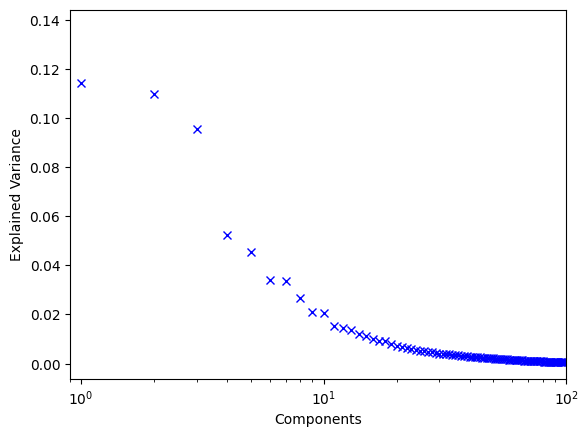

In [11]:
# todo: robust PCA?
pca = PCA(n_components=100, whiten=True)
pca.fit(StandardScaler().fit_transform(res.iloc[:,1:]))

plt.plot(pca.explained_variance_ratio_, 'bx')
plt.xscale('log')
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.xlim(.9, pca.n_components_)

Plot, colored by various parameters

/home/mshugay/Python-3.11.4/Python-3.11.4/Python/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


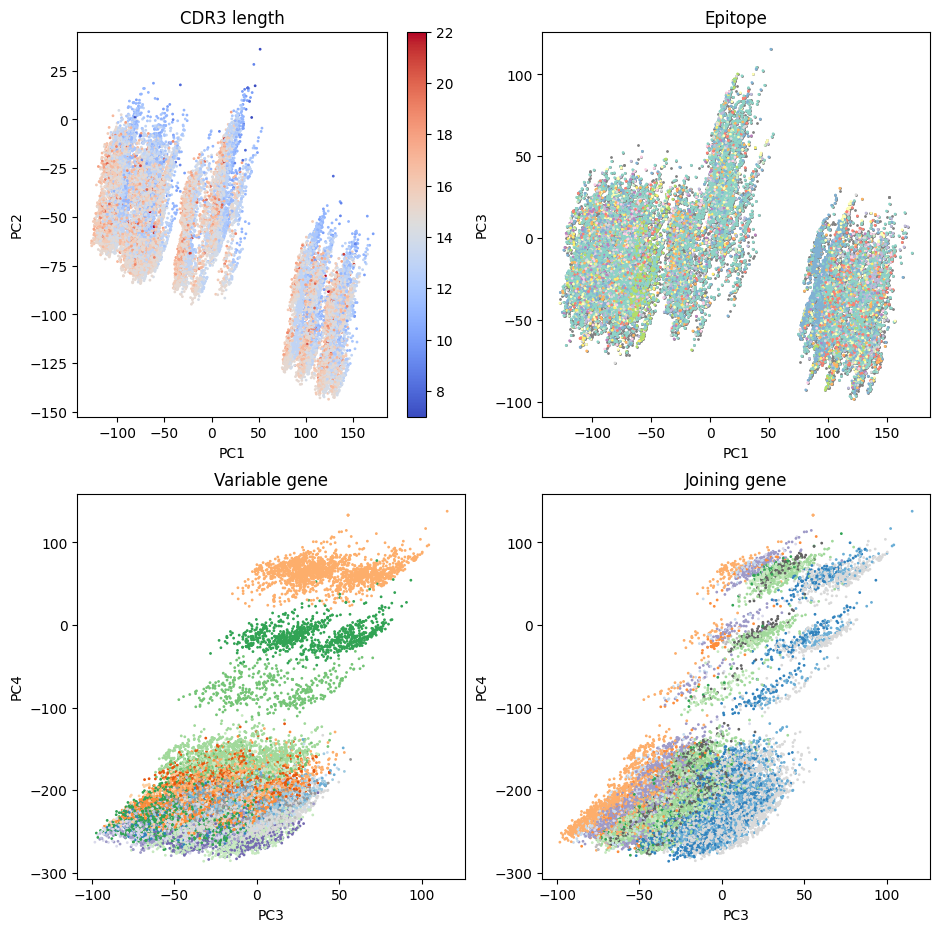

In [12]:
v_fac = {v: i for i, v in enumerate(sorted(set(x.v.id for x in data)))}
j_fac = {j: i for i, j in enumerate(sorted(set(x.j.id for x in data)))}
epi = [x.payload['vdjdb'].epitope for x in data] # todo - make (dot)vdjdb not ['vdjdb']
epi = [x for x, count in Counter(epi).items() if count >= 100]
epi_fac = {j: i for i, j in enumerate(epi)}
epi_x = [epi_fac.get(x.payload['vdjdb'].epitope, -1) for x in data]
good_epi_ids = [i for (i, x) in enumerate(epi_x) if x >= 0]
res_rot = pca.transform(res.iloc[:,1:])

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
p0 = axs[0, 0].scatter(res_rot[:, 0], res_rot[:, 1], 
                       c=[len(x.cdr3aa) for x in data], 
                       cmap='coolwarm', s=1)
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].set_title('CDR3 length')
fig.colorbar(p0)

axs[0, 1].scatter(res_rot[:, 0], res_rot[:, 2], 
            c='grey', s=1)
axs[0, 1].scatter(res_rot[good_epi_ids, 0], res_rot[good_epi_ids, 2], 
            c=[epi_x[i] for i in good_epi_ids], 
            cmap='Set3', s=1)
axs[0, 1].set_xlabel('PC1')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].set_title('Epitope')

axs[1, 0].scatter(res_rot[:, 2], res_rot[:, 3], 
            c=[v_fac[x.v.id] for x in data], 
            cmap='tab20c', s=1)
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].set_title('Variable gene')

axs[1, 1].scatter(res_rot[:, 2], res_rot[:, 3], 
            c=[j_fac[x.j.id] for x in data], 
            cmap='tab20c', s=1)
axs[1, 1].set_xlabel('PC3')
axs[1, 1].set_ylabel('PC4')
axs[1, 1].set_title('Joining gene')
plt.show()

UMAP analysis

Text(0.5, 1.0, 'Epitope')

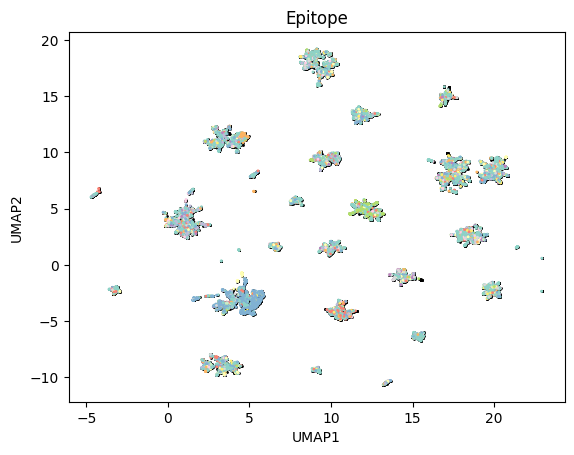

In [14]:
res_umap = um.UMAP().fit_transform(res_rot)
plt.scatter(res_umap[:, 0], res_umap[:, 1], 
            c='k', s=1)
plt.scatter(res_umap[good_epi_ids, 0], res_umap[good_epi_ids, 1], 
            c=[epi_x[i] for i in good_epi_ids], 
            cmap='Set3', s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Epitope')